In [168]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
from scipy.signal import find_peaks, butter, filtfilt, freqz, stft
from sklearn.decomposition import FastICA, PCA
from sklearn.cluster import DBSCAN

from pyod.models.ecod import ECOD
from pyod.models.copod import COPOD

In [169]:
import warnings
warnings.filterwarnings('ignore')

## Filter Methods

In [170]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    """
    Design a Butterworth bandpass filter.

    Parameters:
    -----------
    lowcut : float
        The lower cutoff frequency of the bandpass filter in Hz.
    highcut : float
        The upper cutoff frequency of the bandpass filter in Hz.
    fs : float
        The sampling frequency of the signal in Hz.
    order : int, optional
        The order of the filter, which determines the steepness of the filter's 
        roll-off. Higher orders result in a sharper transition (default is 4).

    Returns:
    --------
    b, a : ndarray, ndarray
        The numerator (`b`) and denominator (`a`) coefficients of the IIR filter.
        
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Applies the Butterworth bandpass filter to the data.

    Parameters:
    -----------
    data : ndarray
        Raw data to be filtered.
    lowcut : float
        The lower cutoff frequency of the bandpass filter in Hz.
    highcut : float
        The upper cutoff frequency of the bandpass filter in Hz.
    fs : float
        The sampling frequency of the signal in Hz.
    order : int, optional
        The order of the filter, which determines the steepness of the filter's 
        roll-off. Higher orders result in a sharper transition (default is 4).

    Returns:
    --------
    y : ndarray
        Filtered data
        
    """
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def max_finder(data):
    """
    Finds the maximum value among a set of lists
    """
    maxv = 0
    for i in range(0, len(data)):
        temp_max = max(abs(data[i]))
        if temp_max > maxv:
            maxv = temp_max
    return maxv
        
def normalizer(data, maxv):
    """
    Normalizes the data to values between [-1, 1]
    """
    norm_data = data/maxv
    return norm_data




def detect_heartbeat_irregularities(fetal_heartbeat, sampling_rate=360, threshold_factor=2.5, print_irregularities=True):
    """
    Detects irregularities in the fetal heartbeat sequence by analyzing intervals and amplitudes.

    Parameters:
    -----------
    fetal_heartbeat : ndarray
        Array of the fetal heartbeat signal.
    sampling_rate : float
        The sampling rate of the signal in Hz.
    threshold_factor : float, optional
        Multiplier for standard deviation to identify irregular intervals and amplitudes (default is 2).
    print_irregularities : bool, optional
        If True, prints details about detected irregularities.

    Returns:
    --------
    irregular_intervals : list of tuples
        List containing indices and values of intervals that are irregular.
    irregular_amplitudes : list of tuples
        List containing indices and values of amplitude peaks that are irregular.
    """
    # Detect peaks in the fetal heartbeat signal
    peaks, properties = find_peaks(fetal_heartbeat, height=np.mean(fetal_heartbeat), distance=sampling_rate/360)
    peak_times = peaks / sampling_rate  # Convert peak indices to time
    peak_amplitudes = properties["peak_heights"]

    # Calculate interbeat intervals (time between each peak)
    intervals = np.diff(peak_times)

    # Detect irregular intervals
    mean_interval = np.mean(intervals)
    std_interval = np.std(intervals)
    interval_threshold = mean_interval + threshold_factor * std_interval
    irregular_intervals = [(i, interval) for i, interval in enumerate(intervals) if interval > interval_threshold]

    # Detect irregular amplitudes
    mean_amplitude = np.mean(peak_amplitudes)
    std_amplitude = np.std(peak_amplitudes)
    amplitude_threshold = mean_amplitude + threshold_factor * std_amplitude
    irregular_amplitudes = [(i, amp) for i, amp in enumerate(peak_amplitudes) if amp > amplitude_threshold]

    # Print detected irregularities
    if print_irregularities:
        print("Irregular Intervals:")
        for idx, interval in irregular_intervals:
            print(f"Interval {idx} with length {interval:.2f} seconds (exceeds {interval_threshold:.2f} seconds)")
        
        print("\nIrregular Amplitudes:")
        for idx, amp in irregular_amplitudes:
            print(f"Peak {idx} with amplitude {amp:.2f} (exceeds {amplitude_threshold:.2f})")
    
    return irregular_intervals, irregular_amplitudes



def normalize_recordings(recordings, target_length):
    """
    Normalize recordings to a fixed length by padding or truncating.
    
    Parameters:
    -----------
    recordings : list of ndarray
        List of 1D numpy arrays representing recordings of varying lengths.
    target_length : int
        The fixed length to which all recordings should be normalized.
    
    Returns:
    --------
    np.ndarray
        2D numpy array with shape (n_recordings, target_length), where each
        row corresponds to a normalized recording.
    """
    normalized = []
    for rec in recordings:
        if len(rec) > target_length:
            # Truncate if longer
            normalized.append(rec[:target_length])
        elif len(rec) < target_length:
            # Pad with zeros if shorter
            padding = np.zeros(target_length - len(rec))
            normalized.append(np.concatenate([rec, padding]))
        else:
            # No changes if already the target length
            normalized.append(rec)
    
    return np.array(normalized)


## Apply ICA

In [171]:
def apply_ica(path):

    """
    Applies ICA to the data

    Parameters:
    -----------
    path: string
        the path to the .mat file containing the recordings

    Returns:
    --------
    result: ndarray
        array of shape (4, recording length) with the signals after they were unmixed
        
    """


    data = loadmat(path)
    values = data['val']
    # print(values[0].shape)
    # apply ICA on data
    ica = FastICA()
    result = np.transpose(ica.fit_transform(np.transpose(values[0])))

    # Make sure that the amplitudes ar4e positives for consistency (sometimes ICA makes them negative)
    results = []
    for arr in result:
        if abs(np.min(arr)) > abs(np.max(arr)):
            arr = -arr
        results.append(arr)

            
    return np.array(results)

def post_process(result, lowcut, highcut, fs=360, plot=False):
    """
    Post process the data by using the bandpass filter

    Parameters:
    -----------
    result : ndarray
        the result of ICA
    lowcut : float
        The lower cutoff frequency of the bandpass filter in Hz.
    highcut : float
        The upper cutoff frequency of the bandpass filter in Hz.
    fs : int, optional
        Sampling frequency in Hz (default is 360).
    plot : bool, optional
        Whether to plot the filtered signal (default is False).

    Returns:
    --------
    results: ndarray
        An array of shape (4, recording length) with the signals after filtering.
    """
    results = []
    X = np.linspace(0, len(result[0]) / fs, len(result[0]))

    for i, component in enumerate(result):
        # filtered_signal = apply_bandpass_filter(component, lowcut, highcut, fs)
        filtered_signal = component
        results.append(filtered_signal)
        # print(len(find_peaks(filtered_signal)[0]))
        if plot:
            plt.figure(figsize=(14, 6))
            plt.plot(X, filtered_signal, label=f"Channel {i+1} Filtered")
            plt.title(f"Filtered Signal (Channel: {i+1})")
            plt.legend()
            plt.show()

    return np.array(results)


## Statistics

In [172]:
def calculate_statistics(data, threshold, sampling_rate, print_statistics=True):
    """
    Extracts local maxima from a continuous data stream if they exceed a specified threshold.
    Additionally, calculates the average frequency and standard deviation of these maxima.

    Args:
    data (iterable): The result of the post processing
    threshold (float): The minimum value for a local maximum to be considered.
    sampling_rate (float): The sampling rate of the data in Hz

    Returns:
    tuple: A tuple containing:
        - list of indices of maxima above the threshold,
        - list of values of maxima above the threshold,
        - average frequency of maxima (1 / average interval),
        - standard deviation of intervals between maxima.
    """  
    # Calculate the differences
    differences = np.diff(data)

    # Identify local maxima
    local_maxima = (differences[:-1] > 0) & (differences[1:] < 0)
    local_maxima_indices = np.where(local_maxima)[0] + 1

    # Filter local maxima according to threshold
    filtered_maxima = [data[idx] for idx in local_maxima_indices if data[idx] > threshold]
    filtered_indices = [idx for idx in local_maxima_indices if data[idx] > threshold]
    
    # Calculate mean and standard deviation for frequency
    intervals = np.diff(filtered_indices) / sampling_rate  # Convert samples to time intervals
    average_frequency = 1 / np.mean(intervals) if len(intervals) > 0 else 0
    std_frequency = np.std(intervals) if len(intervals) > 0 else 0
    
    # Calculate mean and standard deviation for amplitude
    average_amplitude = np.mean(filtered_maxima) if len(filtered_maxima) > 0 else 0
    std_amplitude = np.std(filtered_maxima) if len(filtered_maxima) > 0 else 0

    if print_statistics:
        print(f"Average heartbeat frequency: {average_frequency} Hz")
        print(f"Standard deviation of heartbeat frequency: {std_frequency} sec")
        print(f"Average heartbeat amplitude: {average_amplitude} ")
        print(f"Standard deviation of heartbeat amplitude: {std_amplitude} ")
        

    return filtered_indices, filtered_maxima, average_frequency, std_frequency, average_amplitude, std_amplitude

def show_statistics(data, sampling_rate=360, print_statistics=True):
    """
    Calculates and prints statistics of maternal and fetal heartbeat from ICA components.

    Parameters:
    -----------
    data : List of signals from different ICA components after processing.
    sampling_rate : int
        Sampling rate of the signal in Hz.
    print_statistics : bool, optional
        Whether to print the statistics (default is True).

    Returns:
    --------
    Tuple containing statistics of the mother and the embryo.
    """
    statistics = []
    for i, component in enumerate(data):
        threshold = np.mean(component) + 3 * np.std(component)
        component_statistics = calculate_statistics(component, threshold, sampling_rate, print_statistics=False)
        
        if component_statistics[2] > 0:  # Only include valid components
            statistics.append(component_statistics)
    
    # Sort by frequency to distinguish fetal (higher) from maternal (lower) heartbeat
    statistics.sort(key=lambda x: x[2])
    if len(statistics) >= 2:
        stats_mother, stats_embryo = statistics[-1], statistics[0]  # Lowest frequency as mother, highest as embryo
        
        if print_statistics:
            print("Mother's Heartbeat Statistics:")
            print(f"Frequency: {stats_mother[2]:.2f} Hz ± {stats_mother[3]:.2f} sec")
            print(f"Amplitude: {stats_mother[4]:.2f} ± {stats_mother[5]:.2f}")
            print("\nFetus's Heartbeat Statistics:")
            print(f"Frequency: {stats_embryo[2]:.2f} Hz ± {stats_embryo[3]:.2f} sec")
            print(f"Amplitude: {stats_embryo[4]:.2f} ± {stats_embryo[5]:.2f}")
        
        return stats_mother, stats_embryo
    else:
        print("Not enough valid components detected.")
        return None, None
    

## Extract Heartbeats

In [173]:
def detect_irregularities(features, eps=41, min_samples=1):
    """
    Detects irregularities in heart rate data using DBSCAN clustering.

    Parameters:
    -----------
    features : ndarray
        Array of shape (n_samples, n_features) containing features for clustering.
        Example: [[RR_interval1, rate_change1], [RR_interval2, rate_change2], ...]
    eps : float
        The maximum distance between two samples for them to be considered as in the same neighborhood.
    min_samples : int
        The number of samples in a neighborhood for a point to be considered a core point.

    Returns:
    --------
    labels : ndarray
        Cluster labels for each sample (-1 indicates an outlier).
    """
    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(features)
    
    return labels


def detect_outliers(features, method=ECOD()):
    """
    Detect irregular heartbeats by using ECOD (outlier detection)

    Parameters:
    -----------
    features : ndarray
        Array of shape (n_samples, n_features) containing features for clustering.
        Example: [[RR_interval1, rate_change1], [RR_interval2, rate_change2], ...]

    Returns:
    labels : ndarray
        Cluster labels for each sample (1 indicates an outlier, 0 indicates inlier).
    """
    ecod = method
    return ecod.fit_predict(features)



In [174]:
def extract_heartbeats(data, sampling_rate=360):
    """
    Extracts and returns the heartbeat sequences of the mother and fetus from the data.

    Parameters:
    -----------
    data : list of ndarrays
        List of signals corresponding to different ICA components after post-processing.
    sampling_rate : float
        The sampling rate of the signal in Hz.

    Returns:
    --------
    tuple: Containing the heartbeat sequences for the mother and fetus.
        - mother_sequence: ndarray of the mother's heartbeat sequence
        - fetus_sequence: ndarray of the fetus's heartbeat sequence
    """
    # Define lists to hold statistics and heartbeat sequences
    heartbeat_sequences = []
    statistics = []

    for i, component in enumerate(data):
        # Calculate a threshold to detect heartbeats in the component
        threshold = np.mean(component) + 2.5 * np.std(component)
        # Get the statistics for this component
        component_stats = calculate_statistics(component, threshold, sampling_rate, print_statistics=False)
        
        # Append the component and stats if valid heartbeat sequence is detected
        if component_stats[2] != 0:  # Only consider components with detected heartbeats
            heartbeat_sequences.append(component)
            statistics.append(component_stats)

    # Sort sequences by frequency to distinguish fetal (higher) from maternal (lower) heartbeat
    sequences_and_stats = sorted(zip(heartbeat_sequences, statistics), key=lambda x: x[1][2])

    # Separate into mother and fetus sequences based on frequency
    mother_sequence, _ = sequences_and_stats[0]  # Lowest frequency is maternal
    fetus_sequence, _ = sequences_and_stats[-1]  # Highest frequency is fetal

    return mother_sequence, fetus_sequence

    

def plot_heartbeats(mother_heartbeats, fetus_heartbeats, plots_per_iteration=9, sampling_rate=360):
    """
    Plots the mother's and fetus's heartbeat sequences in a grid layout, with up to 9 plots shown per iteration.

    Parameters:
    -----------
    mother_heartbeats : list of ndarrays
        List of arrays, each containing the mother's heartbeat sequence for a dataset.
    fetus_heartbeats : list of ndarrays
        List of arrays, each containing the fetus's heartbeat sequence for a dataset.
    sampling_rate : float
        The sampling rate of the signal in Hz.
    plots_per_iteration : int, optional
        Number of plots to show in each iteration (default is 9).
    """
    num_datasets = len(mother_heartbeats)
    
    for start in range(0, num_datasets, plots_per_iteration):
        fig, axes = plt.subplots(3, 3, figsize=(15, 10))
        fig.suptitle(f"Heartbeat Sequences for Datasets {start + 1} to {min(start + plots_per_iteration, num_datasets)}", fontsize=16)

        for i, ax in enumerate(axes.flat):
            index = start + i
            if index >= num_datasets:
                ax.axis("off")  # Turn off unused subplots
                continue

            # Get current mother and fetus heartbeat sequences
            mother = mother_heartbeats[index]
            fetus = fetus_heartbeats[index]

            # Define time axes based on the length of each sequence
            time_mother = np.linspace(0, len(mother) / sampling_rate, len(mother))
            time_fetus = np.linspace(0, len(fetus) / sampling_rate, len(fetus))

            # Plot the mother and fetus heartbeat sequences on the current subplot
            ax.plot(time_mother, mother, label="Mother", color="blue", alpha=0.7)
            ax.plot(time_fetus, fetus, label="Fetus", color="red", alpha=0.7)
            ax.set_title(f"Dataset {index + 1}")
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Amplitude")
            ax.legend()

        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle
        plt.show()


# Plot Heartbeats

In [175]:
def plot_clusters_with_pca(data, labels):
    """
    Reduce data to 2D using PCA and plot clusters.
    
    Parameters:
    -----------
    data : ndarray
        High-dimensional input data of shape (n_samples, n_features).
    labels : ndarray
        Cluster labels from DBSCAN or another clustering algorithm.
    """
    # Reduce dimensions to 2D using PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    
    # Plot results
    plt.figure(figsize=(8, 6))
    
    unique_labels = set(labels)
    for label in unique_labels:
        if label == -1:  # Outliers
            color = 'k'  # Black for outliers
            label_name = "Outliers"
        else:
            color = plt.cm.tab10(label / max(unique_labels))  # Unique color per cluster
            label_name = f"Cluster {label}"
        
        cluster_points = reduced_data[labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    c=[color], label=label_name, s=50, alpha=0.6)
    
    plt.title("PCA-based Cluster Visualization")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_clusters_with_pca_3d(data, labels):
    pca = PCA(n_components=3)
    reduced_data = pca.fit_transform(data)
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    unique_labels = set(labels)
    for label in unique_labels:
        if label == -1:
            color = 'k'
            label_name = "Outliers"
        else:
            color = plt.cm.tab10(label / max(unique_labels))
            label_name = f"Cluster {label}"
        
        cluster_points = reduced_data[labels == label]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], 
                   c=[color], label=label_name, s=50, alpha=0.6)
    
    ax.set_title("PCA-based Cluster Visualization (3D)")
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_zlabel("PC 3")
    ax.legend()
    plt.show()


def plot_irregular_heartbeats(recordings, dbscan_labels, sampling_rate=360):
    """
    Plots the time-series of fetal heartbeats not clustered into the largest cluster by DBSCAN,
    with each heartbeat in a separate subplot.

    Parameters:
    - recordings: ndarray, shape (n_samples, n_timesteps)
        The time-series data of fetal heartbeats.
    - dbscan_labels: ndarray, shape (n_samples,)
        Cluster labels assigned by DBSCAN, where -1 indicates noise.
    - sampling_rate: float
        Sampling rate of the heartbeat recordings (default=1).

    Returns:
    - None
    """
    # Identify the largest cluster
    unique_labels, counts = np.unique(dbscan_labels, return_counts=True)
    largest_cluster_label = unique_labels[np.argmax(counts)]

    # Find indices of recordings not in the largest cluster
    non_largest_cluster_indices = dbscan_labels != largest_cluster_label
    irregular_heartbeats = recordings[non_largest_cluster_indices]

    # Create subplots for each irregular heartbeat
    num_irregular = irregular_heartbeats.shape[0]
    cols = 3  # Number of columns in the grid
    rows = (num_irregular + cols - 1) // cols  # Calculate rows needed for all subplots

    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows), squeeze=False)
    time_axis = np.arange(recordings.shape[1]) / sampling_rate

    for i, heartbeat in enumerate(irregular_heartbeats):
        row, col = divmod(i, cols)
        ax = axes[row, col]
        ax.plot(time_axis, heartbeat, label=f"Irregular HB {i + 1}")
        ax.set_title(f"Irregular HB {i + 1}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Amplitude")
        ax.grid(True)
        ax.legend()

    # Remove empty subplots
    for i in range(num_irregular, rows * cols):
        row, col = divmod(i, cols)
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()

In [176]:
def correct_labels(labels):
    """
    If the labels do not adhere to 0 = inlier, 1 = outlier this method fixed that

    Parameters:
    -----------
    labels: ndarray
        Array of labels

    Returns:
    -----------
    new_labels: ndarray
        Array of the correct version of labels
    """


    values, counts = np.unique(labels, return_counts=True)
    inlier = values[np.argmax(counts)]  # this is the value used for inliers
    new_labels = labels.copy()
    new_labels[np.where(labels == inlier)[0]] = 0
    new_labels[np.where(labels != inlier)[0]] = 1

    return new_labels

def compare_findings(heartbeats, labels1, labels2):
    """
    Compare two methods by plotting the irregularities they agree on

    Parameters:
    -----------
    heartbeats: ndarray, shape (n_samples, n_timesteps)
        The time-series data of fetal heartbeats
    labels1: ndarray
        Array of labels for method 1
    labels2: ndarray 
        Array of labels for method 2
    """

    # In case the labels do not only contain 0 and 1 we correct this here
    if (labels1 > 1).any(): labels1 = correct_labels(labels1)
    if (labels2 > 2).any(): labels2 = correct_labels(labels2)

    # Check where the two methods agree and plot those instances
    agreed_irregularities = np.bitwise_and(labels1, labels2)
    if (agreed_irregularities == 0).all():
        print('The Methods do not agree on any irregularities')
    else:
        plot_irregular_heartbeats(heartbeats, agreed_irregularities)

        

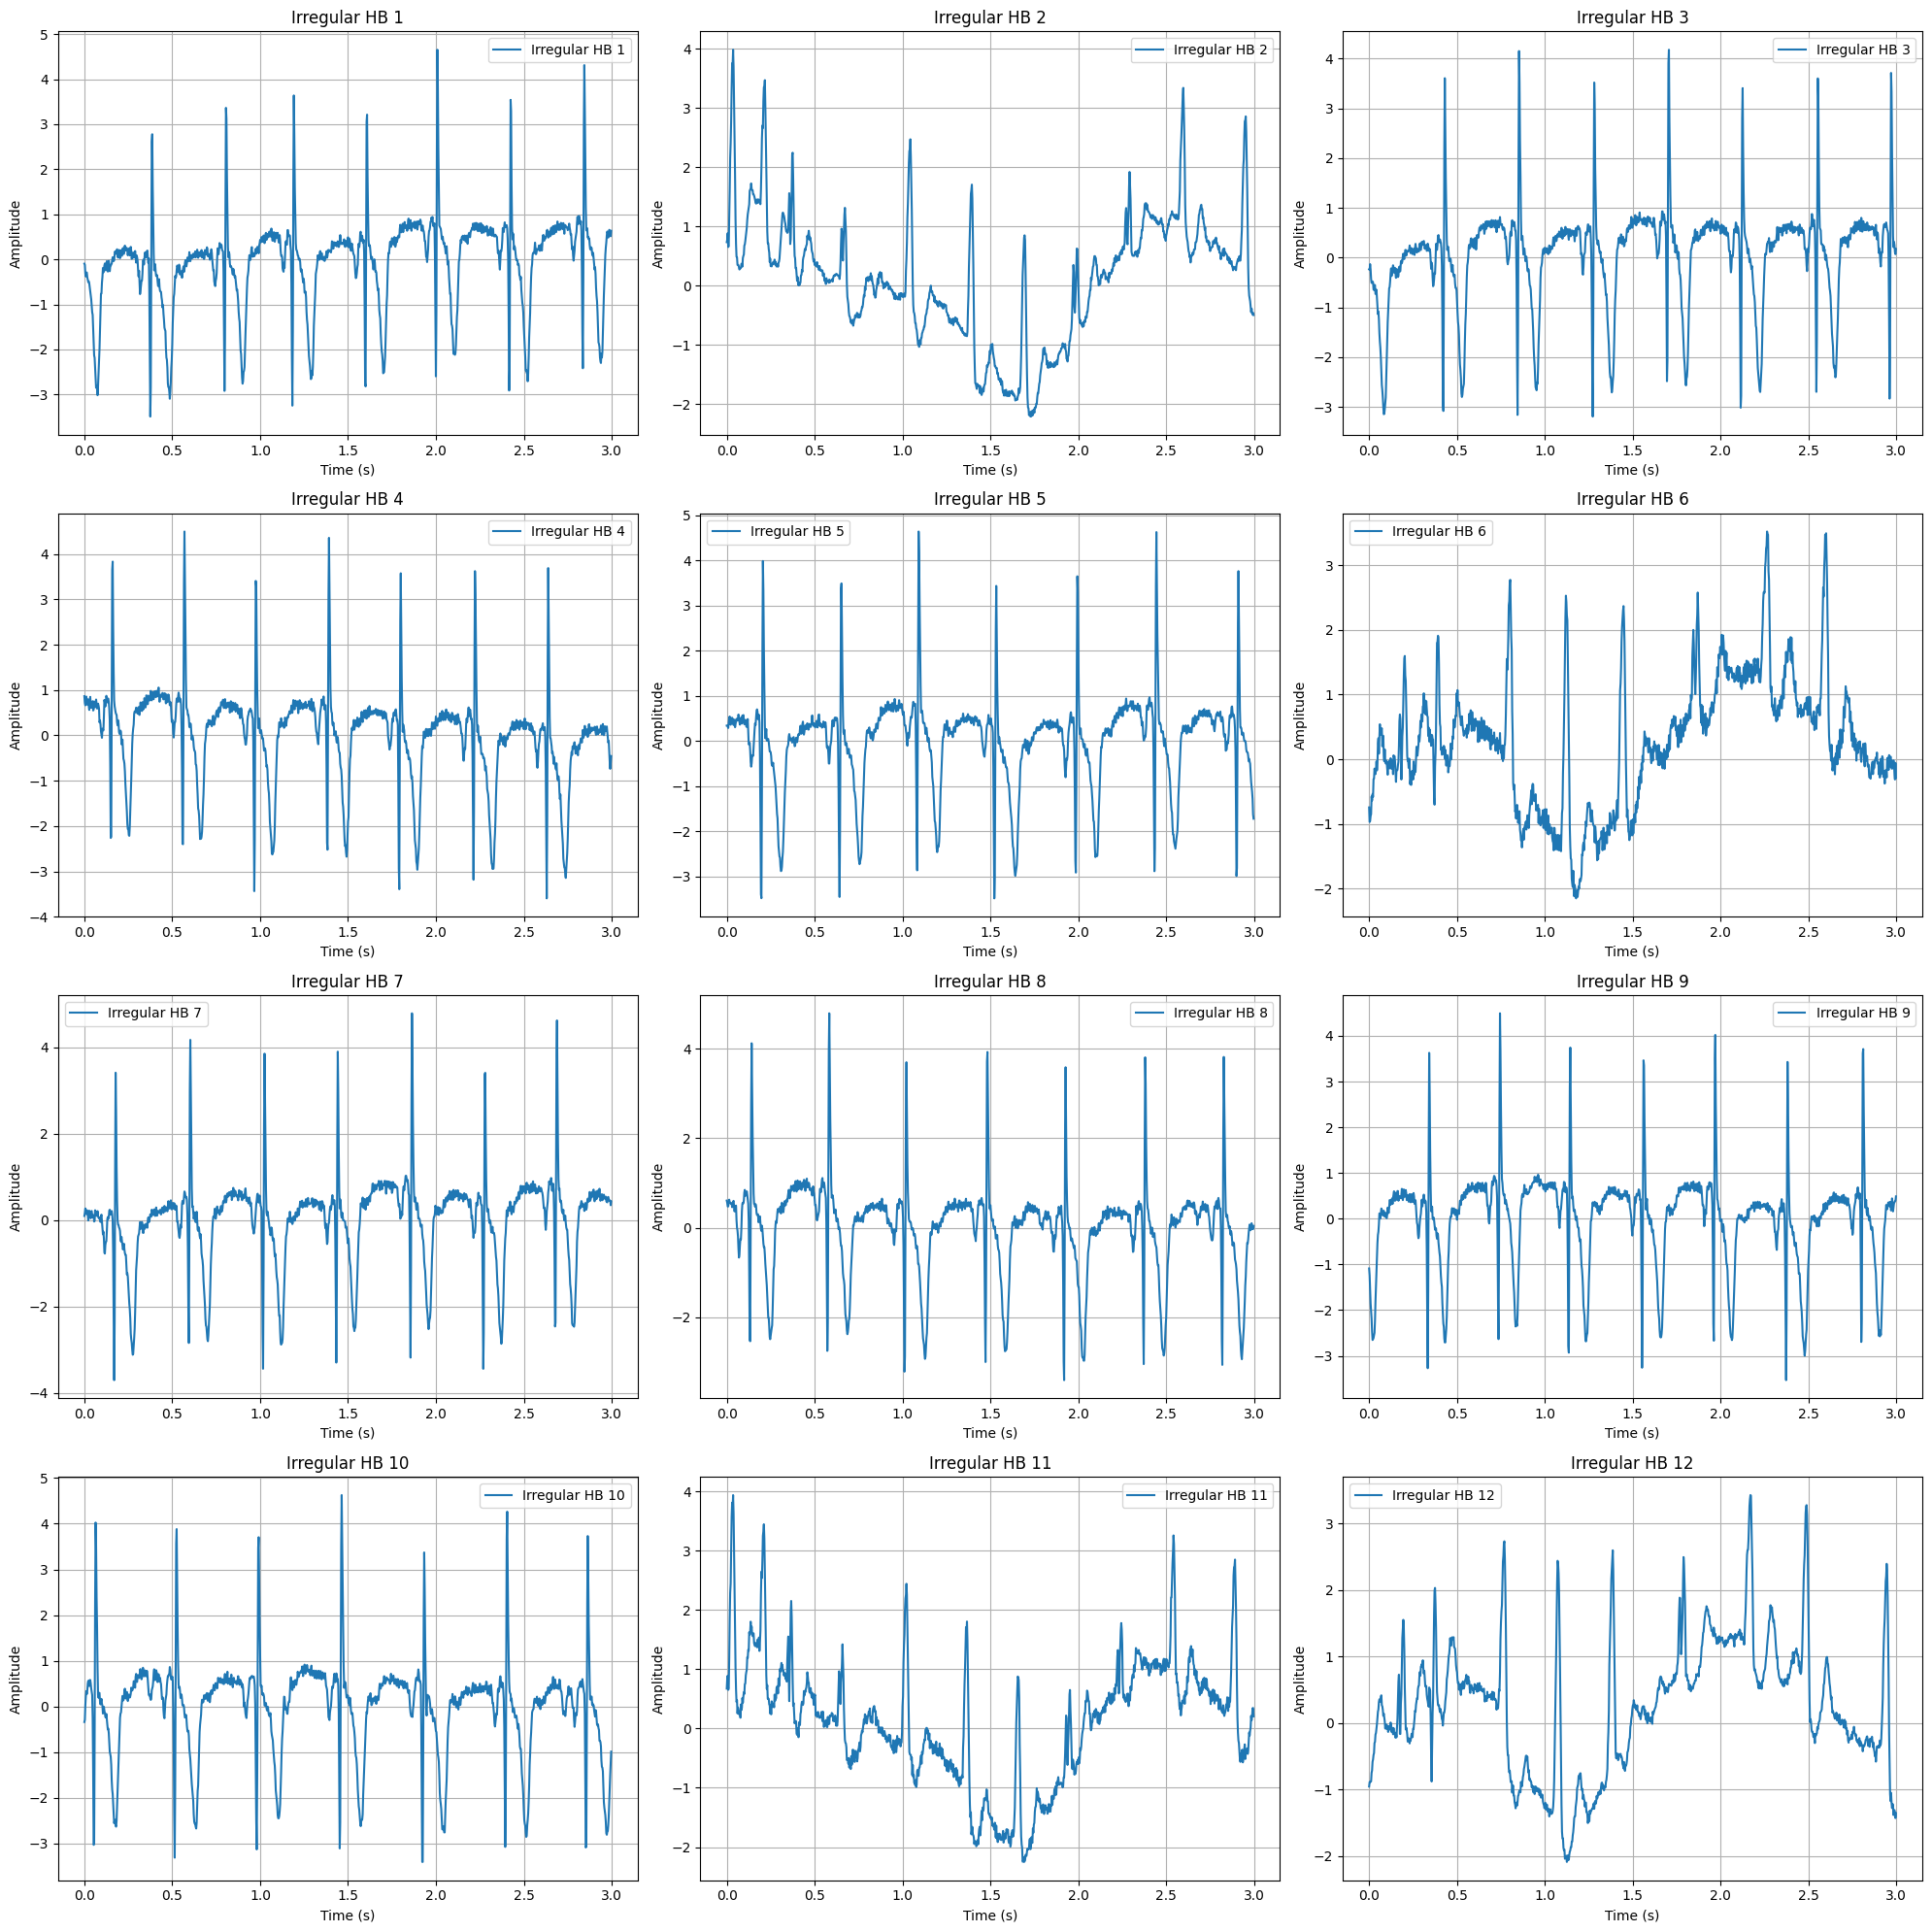

In [177]:
if __name__ == '__main__':
    base_path = 'data/'
    mothers = []
    fetuses = []
    min_length = 1000000000
    for i in range(153):
        #print(f'{base_path}{str(i).zfill(3)}.mat')
        file_path = f'{base_path}{str(i).zfill(3)}.mat'
        results = apply_ica(file_path)
        results = post_process(results, 0.00001, 20, plot=False)
        #print(results.shape)
        mother, fetus = extract_heartbeats(results, 360)
        min_length = min(min_length, len(fetus))
        mothers.append(mother)
        fetuses.append(fetus)
        #print()

    fetal_heartbeat = normalize_recordings(fetuses, min_length)
    labels1 = detect_outliers(fetal_heartbeat)
    labels2 = detect_outliers(fetal_heartbeat, COPOD()) # The COPOD() method can be swapped out with almost any outlier detector from the pyod library
    labels3 = detect_irregularities(fetal_heartbeat)

    compare_findings(fetal_heartbeat, labels1, labels2)

    # plot_clusters_with_pca(fetal_heartbeat, labels)
    # plot_clusters_with_pca_3d(fetal_heartbeat, labels)
    # plot_irregular_heartbeats(fetal_heartbeat, labels1)
